In [154]:
import pandas as pd
import os
import librosa
import numpy as np
import scipy
import re
from collections import Counter
#Data handling
from sklearn.model_selection import train_test_split

# Models 
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Normalizer
from sklearn.preprocessing import MinMaxScaler

#Pickling
from six.moves import cPickle as pickle

#Metrics
from sklearn.metrics import average_precision_score, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.style as ms
import librosa.display
import IPython.display as ipd
import seaborn
ms.use('seaborn-muted')
%matplotlib inline

x_train = []
y_train = []
x_test = []
y_test = []

In [158]:
def get_gender(text):
    text = text[len(text)-4]
    if('F' in text):
        return 'F'
    elif('M' in text):
        return 'M'
    else:
        return 'N/A'
    
def get_word_segments(align_file):
    segments = []
    with open(align_file,'r') as openFile:
        read_lines = openFile.readlines()
        lines = read_lines[1:len(read_lines)-1]
        for line in lines:
            splitted = line.split()
            segments.append({'sf': splitted[0], 'ef':splitted[1],'seg_scr':splitted[2],'word':splitted[3]})
    return segments

def get_vote_agreement_emo(lines,emo_priority):
    parsed_votes = list(map(lambda x: re.sub(';','',x.split(':')[1].split('(')[0].strip()).split(),filter(lambda x: x.startswith('C'),lines)))
    flat_votes = [item for sublist in parsed_votes for item in sublist]
    total_votes = len(flat_votes)
    c = Counter(flat_votes)
    scores = list(map(lambda x: c[x]/total_votes,emo_priority))
    max_score = max(scores)
    if(max_score >= 0.5):
        if(len([i for i, j in enumerate(scores) if j == max_score]) > 1):
            return 'xxx'
        else:
            foundEmo = list(emo_priority.values())[scores.index(max_score)]
            print(c)
            print(foundEmo)
            return foundEmo
    return 'xxx'

def generate_IEMOCAP_df(emo_priority):
    xxx_emo_count = 0
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    alignment = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_alignments_path = temp_root + forced_alignment
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    lines = openFile.readlines()
                    for index, line in enumerate(lines):
                        if(line.startswith('[')):
                            line = line.split()
                            emotion = line[4]
                            original_emo = emotion
                            emotion = get_vote_agreement_emo(lines[index+1:index+5],emo_priority)
                            if(original_emo != emotion):
                                print('changed emo', original_emo, 'to',emotion)
                                xxx_emo_count += 1
                            key = line[3]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        
        for conversation in conversations:
            files_path = temp_conversations_path+ conversation
            alignments_path = temp_alignments_path + conversation
            if('.DS_Store' not in files_path):
                files = os.listdir(files_path)
                for file in files:
                    key,suf = file.split('.')
                    if(suf == 'wav'):
                        data[key].append(files_path + '/'+ file)
                        data[key].append(alignments_path + '/'+key+'.wdseg')
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path','alignment_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    full = full.reset_index()
    full['gender'] = full['index'].apply(get_gender)
    print(xxx_emo_count)
    return full

# Models

In [156]:
import basic_models

In [159]:
emo_priority = {'Anger':'ang', 'Sadness':'sad','Happiness':'hap','Neutral':'neu'}
full = generate_IEMOCAP_df(emo_priority)
# data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
# data.head(3)
full



Counter({'Neutral': 2, 'Sadness': 1})
neu
changed emo fru to xxx
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 3})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Happiness': 2, 'Frustration': 1})
hap
changed emo exc to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo sur to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo

changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru 

Counter({'Sadness': 2, 'Frustration': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 2, 'Frustration': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
changed emo fru to xxx
Counter({'Sadness': 2, 'Frustration': 1})
sad
Counter({'Sadness': 2, 'Frustration': 1, 'Anger': 1})
sad
Counter({'Sadness': 2, 'Anger': 1, 'Frustration': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to

changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 3, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo xxx to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Neutral': 1})
ang
changed emo fru to xxx
changed emo fru to x

changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo xxx to ang
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
chang

sad
Counter({'Sadness': 3, 'Anger': 1})
sad
Counter({'Sadness': 3})
sad
Counter({'Sadness': 3})
sad
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Neutral': 2, 'Sadness': 1})
neu
Counter({'Anger': 3})
ang
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 3})
sad
Counter({'Sadness': 3})
sad
Counter({'Sadness': 2, 'Happiness': 1})
sad
Counter({'Happiness': 2, 'Sadness': 1})
hap
Counter({'Happiness': 2, 'Sadness': 1})
hap
Counter({'Happiness': 2, 'Sadness': 1})
hap
Counter({'Sadness': 2, 'Happiness': 1})
sad
Counter({'Happiness': 2, 'Sadness': 1})
hap
Counter({'Sadness': 3})
sad
Counter({'Sadness': 3})
sad
Counter({'Sadness': 3})
sad
Counter({'Sadness': 2, 'Frustration': 1})
sad
Counter({'Sadness': 3})
sad
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru t

Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Other': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Other': 1})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 2, 'Happiness': 1, 'Other': 1})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Happiness': 2, 'Frustration': 1, 'Neutral': 1})
hap
changed emo xxx to hap
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Other': 1})
ang
Counter({'Anger': 2, 'Other': 1})
ang
Counter({'Sadness': 2, 'Happiness': 1, 'Neutral': 1})
sad
Counter

Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Sadness': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Anger': 3, 'Frustration': 1, 'Disgust': 1})
ang
changed emo fru to xxx
Counter({'Neutral': 2, 'Anger': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({

changed emo exc to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to xxx
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo fru to ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to ang
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1, 'Anger': 1})
neu
changed emo xxx to neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neut

changed emo fru to ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to ang
changed emo fru to xxx
Counter({'Anger': 4, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1, 'Disgust': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo fru to ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1, 'Other': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1, 'Other': 1})
ang
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1, 'Other': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 2})
ang
changed emo fru to xxx
Counter({'Anger': 3, 'Frustration': 2, 'Surprise': 1})
ang
changed emo xxx to ang
Counter({'Anger': 4, 'Frustration': 1, 'Surprise': 1})
ang
Counter({'Anger': 4, 'Fr

Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 2, 'Anger': 1, 'Neutral': 1})
sad
Counter({'Frustration': 2, 'Sadness': 2})
sad
changed emo xxx to sad
Counter({'Sadness': 3})
sad
Counter({'Sadness': 3})
sad
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Sadness': 2, 'Frustration': 1, 'Neutral': 1})
sad
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter

changed emo exc to xxx
changed emo exc to xxx
Counter({'Happiness': 3})
hap
Counter({'Sadness': 3, 'Frustration': 1})
sad
Counter({'Sadness': 4, 'Frustration': 1})
sad
changed emo sad to xxx
Counter({'Sadness': 3, 'Frustration': 1, 'Fear': 1})
sad
Counter({'Sadness': 3, 'Other': 1, 'Fear': 1})
sad
Counter({'Sadness': 2, 'Happiness': 1, 'Other': 1})
sad
Counter({'Sadness': 3, 'Frustration': 1})
sad
Counter({'Sadness': 4, 'Frustration': 1})
sad
Counter({'Sadness': 4, 'Frustration': 2})
sad
Counter({'Sadness': 3, 'Other': 1})
sad
changed emo sad to xxx
Counter({'Sadness': 3, 'Frustration': 1})
sad
Counter({'Sadness': 3, 'Other': 1})
sad
Counter({'Sadness': 4, 'Frustration': 1, 'Anger': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 2, 'Frustration': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 3})
sad
changed emo exc to xxx
Counter({'Excited':

Counter({'Sadness': 2, 'Excited': 1})
sad
changed emo exc to xxx
changed emo exc to xxx
changed emo exc to xxx
changed emo exc to xxx
changed emo exc to xxx
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Happiness': 2, 'Excited': 1, 'Other': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Happiness': 2, 'Neutral': 1})
hap
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Happiness': 2, 'Frustration': 1})
hap
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Excited': 2, 'Happiness': 2})
hap
changed emo xxx to hap
Counter({'Sadness': 2, 'Frustration': 1, 'Other': 1})
sad
Counter({'Sadne

changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 2})
neu
Counter({'Neutral': 2, 'Frustration': 2})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Anger': 3, 'Surprise': 1, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Frustration': 2, 'Anger': 2})
ang
changed emo xxx to ang
changed emo fru to xxx
Counter(

changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Sadness': 2, 'Frustration': 1, 'Other': 1})
sad
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
Counter({'Sadness': 2, 'Frustration': 1})
sad
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'

changed emo xxx to sad
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Sadness': 2, 'Frustration': 1})
sad
Counter({'Anger': 2, 'Sadness': 1, 'Frustration': 1})
ang
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 3})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 2, 'F

changed emo fru to xxx
Counter({'Happiness': 3})
hap
Counter({'Happiness': 2, 'Surprise': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Happiness': 2, 'Excited': 1})
hap
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Other': 1})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3, 'Surprise': 1})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Cou

Counter({'Neutral': 2, 'Frustration': 1, 'Disgust': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Frustration': 2, 'Neutral': 2})
neu
changed emo fru to xxx
Counter({'Neutral': 3, 'Frustration': 1, 'Anger': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1, 'Anger': 1})
neu
changed emo neu to xxx
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Other': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 3, 'Frustration': 1})
neu
changed emo neu to xxx
Counter({'Frustration': 2, 'Neutral': 2})
neu
changed emo fru to xxx
changed emo fru to xxx
Counter({'Frustration': 2, 'Neutral': 2})
neu
changed emo fru to neu
Counter({'Frustration': 2, 'Neutral': 2})
neu
changed emo fru to neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Sadness': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustratio

Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Other': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Excited': 1})
neu
Counter

neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
Counter({'Neutral': 3})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx

Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4, 'Fear': 1})
sad
Counter({'Sadness': 4, 'Fear': 1})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4})
sad
Counter({'Sadness': 4, 'Neutral': 1})
sad
Counter({'Sadness': 4, 'Frustration': 1})
sad
Counter({'Sadness': 4, 'Frustration': 1})
sad
Counter({'Neutral': 3, 'Frustration': 1, 'Happiness': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Surprise': 1})
neu
changed emo xxx to neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu
Counter({'Neutral': 3, 'Frustration': 1})
neu


changed emo neu to xxx
Counter({'Happiness': 4, 'Excited': 2})
hap
Counter({'Happiness': 4, 'Excited': 2})
hap
Counter({'Happiness': 4, 'Excited': 1})
hap
Counter({'Neutral': 2, 'Happiness': 1, 'Excited': 1})
neu
Counter({'Neutral': 2, 'Surprise': 1, 'Excited': 1})
neu
changed emo sur to xxx
changed emo exc to xxx
changed emo neu to xxx
Counter({'Happiness': 4})
hap
Counter({'Neutral': 3, 'Happiness': 1})
neu
Counter({'Neutral': 3, 'Excited': 1})
neu
Counter({'Neutral': 3, 'Happiness': 1})
neu
Counter({'Happiness': 2, 'Excited': 1, 'Neutral': 1})
hap
changed emo xxx to hap
Counter({'Happiness': 4, 'Excited': 1, 'Neutral': 1})
hap
Counter({'Happiness': 3, 'Other': 1, 'Excited': 1})
hap
Counter({'Happiness': 3, 'Excited': 1})
hap
Counter({'Neutral': 3, 'Happiness': 1})
neu
changed emo sur to xxx
changed emo sur to xxx
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
Counter({'Neutral': 4})
neu
changed emo exc to xxx
Counter({'Happiness': 4})
hap
Counter({'Neutral': 4})
neu
Counter

changed emo xxx to neu
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
changed emo fru to xxx
Counter({'Anger': 3, 'Frustration': 2})
ang
Counter({'Anger': 4, 'Frustration': 3, 'Disgust': 1})
ang
Counter({'Anger': 3, 'Frustration': 2, 'Surprise': 1})
ang
changed emo xxx to ang
changed emo ang to xxx
changed emo ang to xxx
changed emo ang to xxx
Counter({'Anger': 4, 'Frustration': 2, 'Excited': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Frustration': 1, 'Excited': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Frustration': 2, 'Surprise': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Frustration': 2, 'Disgust': 1})
ang
Counter({'Anger': 4})
ang
Counter({'Anger': 4, 'Other': 2, 'Excited': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Excited': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Excited': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Frustration': 1, 'Disgust': 1})
ang
Counter({'Anger': 4, 'Excited'

neu
Counter({'Anger': 2, 'Other': 1})
ang
Counter({'Anger': 2, 'Other': 1})
ang
Counter({'Anger': 2, 'Neutral': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 2, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Anger': 3})
ang
Counter({'Anger': 3, 'Frustration': 1})
ang
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Neutral': 2, 'Frustration': 1, 'Anger': 1})
neu
changed emo fru to xxx
changed emo fru to xxx
Counter({'Neutral': 2, 'Frustration': 1})
neu
Counter({'Anger': 3})
ang
Counter({'Anger': 3})
ang
Counter({'An

index start_time  end_time  \
0         Ses01F_impro01_F000   006.2901  008.2357   
1         Ses01F_impro01_F001   010.0100  011.3925   
2         Ses01F_impro01_F002   014.8872  018.0175   
3         Ses01F_impro01_F003   019.2900  020.7875   
4         Ses01F_impro01_F004   021.3257  024.7400   
5         Ses01F_impro01_F005   027.4600  031.4900   
6         Ses01F_impro01_F006   038.9650  043.5900   
7         Ses01F_impro01_F007   046.5800  052.1900   
8         Ses01F_impro01_F008   056.1600  058.8225   
9         Ses01F_impro01_F009   061.8700  065.9700   
10        Ses01F_impro01_F010   066.4200  069.3400   
11        Ses01F_impro01_F011   072.4500  082.2600   
12        Ses01F_impro01_F012   085.2700  088.0200   
13        Ses01F_impro01_F013   093.6700  097.0218   
14        Ses01F_impro01_F014   097.8900  102.9600   
15        Ses01F_impro01_F015   103.9700  106.7100   
16        Ses01F_impro01_M000   007.5712  010.4750   
17        Ses01F_impro01_M001   010.9266  014.6649   
18        Ses01F_impro01_M002   016.8352  019.7175   
19        Ses01F_impro01_M003   023.4700  028.0300   
20        Ses01F_impro01_M004   028.3950  031.2117   
21        Ses01F_impro01_M005   031.2660  039.3875   
22        Ses01F_impro01_M006   041.2300  046.9800   
23        Ses01F_impro01_M007   051.4000  057.6400   
24        Ses01F_impro01_M008   058.1800  062.5900   
25        Ses01F_impro01_M009   065.5100  073.0000   
26        Ses01F_impro01_M010   081.5900  086.0300   
27        Ses01F_impro01_M011   087.1500  094.3900   
28        Ses01F_impro01_M012   095.8600  098.6800   
29        Ses01F_impro01_M013   101.8400  107.8700   
...                       ...        ...       ...   
10009  Ses05M_script03_2_M016   087.0900  092.7300   
10010  Ses05M_script03_2_M017   094.5500  098.9600   
10011  Ses05M_script03_2_M018   101.8100  103.9800   
10012  Ses05M_script03_2_M019   104.0100  105.1900   
10013  Ses05M_script03_2_M020   107.9400  113.2900   
10014  Ses05M_script03_2_M021   115.3900  117.7900   
10015  Ses05M_script03_2_M022   118.8300  122.3300   
10016  Ses05M_script03_2_M023   122.3400  123.5900   
10017  Ses05M_script03_2_M024   129.4400  136.1000   
10018  Ses05M_script03_2_M025   136.8800  141.2000   
10019  Ses05M_script03_2_M026   141.9200  149.3500   
10020  Ses05M_script03_2_M027   150.7700  153.7600   
10021  Ses05M_script03_2_M028   154.3900  162.3300   
10022  Ses05M_script03_2_M029   165.2600  169.8100   
10023  Ses05M_script03_2_M030   172.0500  177.6500   
10024  Ses05M_script03_2_M031   179.6000  183.2400   
10025  Ses05M_script03_2_M032   186.8900  188.9900   
10026  Ses05M_script03_2_M033   190.3300  193.9600   
10027  Ses05M_script03_2_M034   196.1700  198.6600   
10028  Ses05M_script03_2_M035   198.8600  201.7200   
10029  Ses05M_script03_2_M036   203.0700  205.2300   
10030  Ses05M_script03_2_M037   210.8600  213.3600   
10031  Ses05M_script03_2_M038   214.7900  216.2300   
10032  Ses05M_script03_2_M039   218.8300  221.3700   
10033  Ses05M_script03_2_M040   227.4800  230.8500   
10034  Ses05M_script03_2_M041   236.5700  244.8300   
10035  Ses05M_script03_2_M042   244.8400  246.5800   
10036  Ses05M_script03_2_M043   246.5900  248.8300   
10037  Ses05M_script03_2_M044   255.8600  260.3300   
10038  Ses05M_script03_2_M045   260.3400  266.3500   

                                                    text  \
0                                           Excuse me.\n   
1                                                Yeah.\n   
2                                  Is there a problem?\n   
3                                             You did.\n   
4      You were standing at the beginning and you dir...   
5          Well what's the problem?  Let me change it.\n   
6      What?  I'm getting an ID.  This is why I'm her...   
7      How am I supposed to get an ID without an ID? ...   
8                               I'm here to get an ID.\n   
9                Like what?  Like a birth certificate?\n   
10             

In [163]:
full.to_csv('data/IEMOCAP_sentences_votebased.csv')
full.groupby('emotion').count()

index  start_time  end_time  text  wav_path  alignment_path  valence  \
emotion                                                                         
ang       1235        1235      1235  1235      1235            1235     1235   
hap        777         777       777   777       777             777      777   
neu       1746        1746      1746  1746      1746            1746     1746   
sad       1098        1098      1098  1098      1098            1098     1098   
xxx       5183        5183      5183  5183      5183            5183     5183   

         arousal  dominance  gender  
emotion                              
ang         1235       1235    1235  
hap          777        777     777  
neu         1746       1746    1746  
sad         1098       1098    1098  
xxx         5183       5183    5183

In [7]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data['emotion'] = data['emotion'].map( emotional_mapping ).astype(int)


In [8]:
#Exclude ['oth', 'xxx', 'dis', 'sur','fea']
data = data[data.emotion < 6]
y = data.emotion
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
# print X_train.shape, y_train.shape
# print X_test.shape, y_test.shape

# try:
#     with open('pickles/base_datasets.pickle','wb') as f:
#         save = {
#             'X_train' : X_train,
#             'X_test' : X_test,
#             'y_train': y_train,
#             'y_test' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to base datasets pickle: ', e)
try:
    with open('pickles/base_datasets.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

In [11]:
def get_sample(data,emotional_mapping,emotion):
    emotion_code = emotional_mapping[emotion]
    emotion_sample = data[data.emotion == emotion_code]
    sample_size = len(emotion_sample)
    oth_emotion_sample = data[data.emotion != emotion_code].sample(n=sample_size)
    sample = pd.concat([oth_emotion_sample,emotion_sample]).sample(frac=1)
    y = map_for_emotion(sample.emotion,emotional_mapping,'ang')
    return sample,y

x,y = get_sample(data,emotional_mapping,'ang')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print X_train.shape, len(y_train)
print X_test.shape, len(y_test)

(1764, 11) 1764
(442, 11) 442


In [10]:
test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav'
def get_mfcc_feature(filename,n_mfcc):
    y, sr = librosa.load(filename)
    #IPython.display.Audio(data=y,rate=sr)
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)
    print("Finished "+ filename)
    return np.mean(mfcc.T,axis=0)

def map_for_emotion(y_list, emotional_mapping,emotion):
    return list(map(lambda x: 1 if x == emotional_mapping[emotion] else 0,y_list))


# MFCC (20) Features - Mel-frequency cepstral coefficients

In [250]:
# x_train = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))
# x_test = list(map(lambda x: get_mfcc_feature(x,20),X_test['wav_path']))
# try:
#     with open('pickles/mfcc20.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to mfcc pickle: ', e)

try:
    with open('pickles/mfcc20.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

In [251]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [252]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [253]:
models_result = compare_models_x_emotions(x_train, x_test, emotions)

In [254]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    76.56       85.03    86.59        74.93   
1                         KNN    76.02       82.18    86.38        70.46   
2         Logistic Regression    76.83       85.16    87.47        75.27   
3               Random Forest    77.71       85.43    89.50        74.86   
4                 Naive Bayes    64.77       73.98    78.59        71.21   
5                  Perceptron    76.56       84.21    86.52        74.93   
6  Stochastic Gradient Decent    76.56       84.82    86.52        74.93   
7                  Linear SVC    76.56       85.03    86.59        74.93   
8               Decision Tree    68.77       77.24    81.71        65.11   

   Anger  Happiness  
0  84.15      92.75  
1  83.06      91.26  
2  86.86      92.82  
3  86.38      92.68  
4  77.51      92.68  
5  62.80      92.75  
6  85.09      12.40  
7  84.42      92.75  
8  79.81      84.21

## Scaled MFCC (20) Features

In [ ]:
def scale_features(x_train, x_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_x_train = scaler.fit_transform(x_train)
#     print(scaled_x_train.min(axis=0))
#     print(scaled_x_train.max(axis=0))
    scaled_x_test = scaler.fit_transform(x_test)
    return scaled_x_train,scaled_x_test

scaled_x_train, scaled_x_test = scale_features(x_train,x_test)

In [ ]:
models_result = compare_models_x_emotions(scaled_x_train, scaled_x_test, emotions)

In [ ]:
models_result

### Invidual Emotion Models

In [ ]:
# compare_models(x_train,ang_train, x_test , ang_test)
# compare_models(x_train,sad_train, x_test , sad_test)
# compare_models(x_train,exc_train, x_test , exc_test)
# compare_models(x_train,neu_train, x_test , neu_test)
# compare_models(x_train,fru_train, x_test , fru_test)
# compare_models(x_train,hap_train, x_test , hap_test)

# RMSE

In [18]:
def get_rmse(filename):
    y, sr = librosa.load(filename)
    rmse = librosa.feature.rmse(y)
    print("Finished "+ filename)
    return rmse[0]

test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav'
rmse = get_rmse(test_file)
rmse.shape

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav


(126,)

In [19]:
# x_train = list(map(lambda x: get_rmse(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_rmse(x),X_test['wav_path']))
# try:
#     with open('pickles/rmse.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to rmse pickle: ', e)
try:
    with open('pickles/rmse.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F015.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M032.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M007.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F005.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M016.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F020.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M005.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F024.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F016.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M009.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F016.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M079.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F006.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M04

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M015.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F019.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M04

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M003.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M039.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M050.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F031.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M051.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M017.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M015.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F013.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F053.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F012.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F007.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F051.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M003.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M017.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F000.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M000.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M001.wav
Finished

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M017.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M052.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M005.wav
Finished data/IEMOCAP_

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F011.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M080.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F021.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F026.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F051.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M052.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F052.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F051.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M012.wav
Fi

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M032.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F047.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_sc

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M064.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M034.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M03

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F000.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F052.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M015.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F027.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M006.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M003.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F034.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M025.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_sc

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F004.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M051.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M036.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M000.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F000.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M007.wa

In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

# Zero Crossing Rate

In [20]:
def get_zcr(filename):
    y,sr = librosa.load(filename)
    zcr = librosa.feature.zero_crossing_rate(y  + 0.0100) # 0.0200 background noise reduction
    return zcr[0] 
    
test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F000.wav'
y,sr = librosa.load(test_file)
zcr = get_zcr(test_file)
zcr.shape


(150,)

In [21]:
# x_train = list(map(lambda x: get_zcr(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_zcr(x),X_test['wav_path']))
# try:
#     with open('pickles/zcr.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to zcr pickle: ', e)
try:
    with open('pickles/zcr.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

#  Fourier Transform

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
--- 0.383305072784 seconds ---
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav


5904

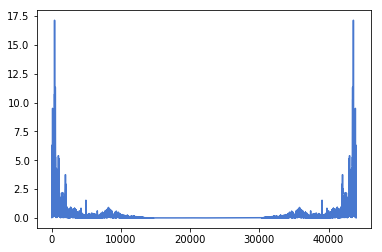

In [15]:
def get_fft(filename):
    y,sr = librosa.load(filename)
    fft = scipy.fft(y)
    print("Finished "+filename)
    return np.absolute(fft)
    
import time
start_time = time.time()
fft = get_fft(test_file)
print("--- %s seconds ---" % (time.time() - start_time))
test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
fft = get_fft(test_file)
plt.plot(fft)
fft.shape

In [ ]:
# x_train = list(map(lambda x: get_fft(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_fft(x),X_test['wav_path']))
# try:
#     with open('pickles/fft.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to fft pickle: ', e)
# try:
#     with open('pickles/fft.pickle','rb') as f:
#         save = pickle.load(f)
#         x_train = save['train_dataset']
#         y_train = save['train_labels']
#         x_test = save['test_dataset']
#         y_test = save['test_labels']
#         del save
# except Exception as e:
#     print('Error at:', e)


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F052.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M017.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F012.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M026.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F013.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F050.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M000.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impr

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M052.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F003.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M027.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_imp

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F013.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F047.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M051.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F006.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M044.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F012.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M000.wa

In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

# Spectrogram

In [22]:
def get_spectrogram(filename,n_fft = 2048):
    y,sr = librosa.load(filename)
    Y = librosa.stft(y, n_fft=n_fft)
    Ymag = librosa.amplitude_to_db(np.absolute(Y))
    print('Finished '+ filename)
    return np.mean(Ymag.T,axis=0)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
stft = get_spectrogram(test_file)
stft2 = get_spectrogram(test_file2)
print(stft.shape,stft2.shape)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((1025,), (1025,))


In [23]:
# x_train = list(map(lambda x: get_spectrogram(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_spectrogram(x),X_test['wav_path']))
# try:
#     with open('pickles/spectrogram.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to spectrogram pickle: ', e)
try:
    with open('pickles/spectrogram.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M063.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M03

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F034.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finished data/IEMOCAP_full

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M010.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F008.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F036.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F058.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F018.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M045.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F016.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M009.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M042.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M066.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M053.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F007.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M015.wav
Finished data/

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F011.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M004.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M020.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M024.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M05

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M017.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F042.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M009.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F004.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F024.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F048.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F049.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav
Finished

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_sc

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M023.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F000.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F011.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M034.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F007.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F039.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F03

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M039.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F012.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M023.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F015.

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M012.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M014.wav
Fi

In [46]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [47]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

((5904, 1025), (1476, 1025))
((5904, 1025), (1476, 1025))


In [48]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [49]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [50]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.46       85.98    87.06        72.22   
1                         KNN    76.42       83.27    85.23        67.82   
2         Logistic Regression    78.52       84.82    87.60        71.41   
3               Random Forest    80.08       86.31    89.63        72.02   
4                 Naive Bayes    51.90       58.60    71.34        51.36   
5                  Perceptron    78.32       68.97    43.29        72.22   
6  Stochastic Gradient Decent    78.32       85.91    86.59        35.84   
7                  Linear SVC    79.47       86.31    88.89        72.02   
8               Decision Tree    71.61       79.67    84.55        65.04   

   Anger  Happiness  
0  84.62      92.28  
1  84.28      91.19  
2  83.40      88.89  
3  86.72      92.28  
4  71.00      48.98  
5  85.91      92.28  
6  85.03      89.02  
7  86.79      10.84  
8  80.56      83.54

# Mel-spectrogram

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((128,), (128,))


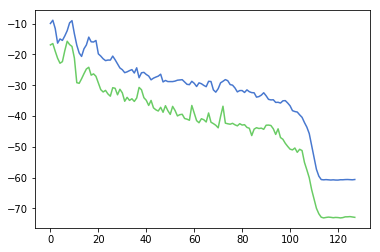

In [24]:
def get_melspectrogram(filename,n_fft = 4096):
    y,sr = librosa.load(filename)
    Y = librosa.feature.melspectrogram(y, n_fft=n_fft)
    Ymag = librosa.power_to_db(Y)
    print('Finished '+ filename)
    return np.mean(Ymag,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
stft = get_melspectrogram(test_file)
stft2 = get_melspectrogram(test_file2)
print(stft.shape,stft2.shape)
plt.plot(stft2)
plt.plot(stft)

In [25]:
# x_train = list(map(lambda x: get_melspectrogram(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_melspectrogram(x),X_test['wav_path']))
# try:
#     with open('pickles/melspectrogram.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to melspectrogram pickle: ', e)
try:
    with open('pickles/melspectrogram.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M015.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F025.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M032.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F000.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F010.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_sc

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M001.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F009.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M002.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F005.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M020.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_sc

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F017.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F058.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F035.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M050.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F008.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M05

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F042.wav
Finished d

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F022.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M018.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M053.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M009.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finished data/

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_sc

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M042.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M038.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M021.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F017.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M020.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F012.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F028.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M05

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M011.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M021.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F004.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F003.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M009.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F009.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M022.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F051.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M052.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F023.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F052.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F049.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M011.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F016.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M000.wav
Finished data/IEMOCAP_full_rel

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M012.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F001.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M045.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M018.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M047.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F023.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F047.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M053.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M045.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_imp

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M006.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M068.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F010.wav


In [72]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [73]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [74]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [75]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.39       85.98    87.26        72.22   
1                         KNN    76.63       83.47    86.52        69.04   
2         Logistic Regression    79.00       86.31    89.50        72.49   
3               Random Forest    80.22       86.25    88.82        71.82   
4                 Naive Bayes    49.86       59.89    70.66        51.76   
5                  Perceptron    78.32       85.84    87.87        71.68   
6  Stochastic Gradient Decent    74.12       68.36    85.23        67.62   
7                  Linear SVC    79.40       85.98    88.89        72.29   
8               Decision Tree    72.02       79.13    83.81        65.58   

   Anger  Happiness  
0  84.62      92.28  
1  85.23      90.99  
2  86.04      92.07  
3  86.04      92.28  
4  70.39      72.29  
5  86.11      92.28  
6  85.16      92.07  
7  85.37      92.28  
8  79.74      84.08

# constant-Q spectrogram

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((84,), (84,))


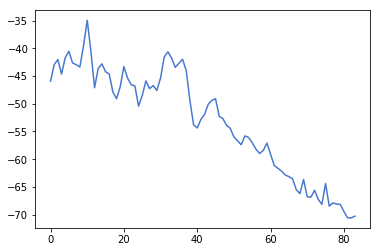

In [26]:
def get_cqt(filename,n_fft = 4096):
    y,sr = librosa.load(filename)
    C = librosa.cqt(y,sr=sr)
    Clog = librosa.amplitude_to_db(np.abs(C))
    print('Finished '+ filename)
    return np.mean(Clog,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
cqt = get_cqt(test_file)
cqt2 = get_cqt(test_file2)
print(cqt.shape,cqt2.shape)
plt.plot(cqt)

In [27]:
# x_train = list(map(lambda x: get_cqt(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_cqt(x),X_test['wav_path']))
# try:
#     with open('pickles/cqt.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to cqt pickle: ', e)
try:
    with open('pickles/cqt.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M063.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F04

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F018.wav
Finished data/IEMOCA

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M036.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F007.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F008.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F058.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M024.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M045.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F015.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M021.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M019.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F011.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M066.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M053.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M010.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M060.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M003.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M018.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M004.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F019.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F02

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F00

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M012.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M016.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M043.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M045.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_sc

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M047.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_imp

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M042.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M019.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M013.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F025.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M050.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M028.

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M053.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F026.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M030.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F005.wa

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F025.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F058.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M062.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F052.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script0

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M016.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M014.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M057.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M038.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M034.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M016.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F00

In [97]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [98]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [99]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [100]:
models_result

Model  Neutral  Excitement  Sadness  Frustration  \
0     Support Vector Machines    78.25       85.98    87.94        72.22   
1                         KNN    77.71       84.15    87.87        68.09   
2         Logistic Regression    78.79       86.45    88.89        71.68   
3               Random Forest    80.69       85.91    89.23        72.29   
4                 Naive Bayes    48.64       61.59    68.29        52.64   
5                  Perceptron    78.32       37.13    61.04        71.88   
6  Stochastic Gradient Decent    28.46       85.91    87.06        72.22   
7                  Linear SVC    78.25       14.02    86.52        72.22   
8               Decision Tree    71.48       79.00    84.28        64.84   

   Anger  Happiness  
0  84.62      92.28  
1  84.21      91.67  
2  86.18      92.21  
3  86.52      92.28  
4  68.70      81.98  
5  85.91      92.28  
6  85.43      92.28  
7  86.52      92.28  
8  79.13      83.60

# Chroma

In [13]:
def get_chroma_stft(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_stft(y,sr=sr)
    print('Finished '+ filename)
    return np.mean(chromagram,axis=1)

def get_chroma_cqt(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_cqt(y,sr=sr)
    print('Finished' + filename)
    return np.mean(chromagram,axis=1)

def get_chroma_cens(filename):
    y,sr = librosa.load(filename)
    chromagram = librosa.feature.chroma_cens(y,sr=sr)
    print('Finished' + filename)
    return np.mean(chromagram,axis=1)

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
test_file2 = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'
chroma_stft = get_chroma_stft(test_file)
chroma2_stft = get_chroma_stft(test_file2)
chroma_cqt = get_chroma_cqt(test_file)
chroma2_cqt = get_chroma_cqt(test_file2)
chroma_cens = get_chroma_cens(test_file)
chroma2_cens = get_chroma_cens(test_file2)
print(chroma_stft.shape,chroma2_stft.shape)
ipd.display(chroma_stft)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
((12,), (12,))


/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)
/usr/local/lib/python2.7/site-packages/librosa/feature/spectral.py:1193: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = scipy.signal.hanning(win_len_smooth + 2)


array([0.59860634, 0.48167456, 0.34980296, 0.2653433 , 0.26157497,
       0.29020645, 0.31987272, 0.44279834, 0.53430804, 0.5186246 ,
       0.47235972, 0.5383219 ])

In [29]:
# x_train = list(map(lambda x: get_chroma_stft(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_stft(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_stft.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma stft pickle: ', e)
try:
    with open('pickles/chroma_stft.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finished d

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M063.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wa

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M03

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F004.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M028.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F001.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M014.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F007.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M019.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F006.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F008.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F008.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F058.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M024.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M028.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M045.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F002.wav
Finished d

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F011.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M066.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M03

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M053.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F029.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M002.wav
Finished data/

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F001.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F046.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F054.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M038.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M039.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M003.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M018.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M031.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F044.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F004.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M010.wav
Fini

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M006.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M044.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M024.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M046.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M05

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F046.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M017.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F042.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F001.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F004.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F024.wa

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F007.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F048.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F049.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M004.wav
Finished

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_sc

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F048.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M023.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M062.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F000.wa

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M054.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F00

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_F011.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M034.wav
Finish

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F007.wav
Finished d

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F039.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F03

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M050.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M015.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M030.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F034.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F016.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M053.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F004.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F015.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F012.wav
Finished

In [30]:
x_train = list(map(lambda x: get_chroma_cqt(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_cqt(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_cqt.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma cqt pickle: ', e)
try:
    with open('pickles/chroma_cqt.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F007.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M015.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F006.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F050.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F027.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F010.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M011.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M007.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M028.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M011.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Fi

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F030.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M020.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M001.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M005.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F019.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M079.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F032.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M045.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M029.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F019.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M042.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M012.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F020.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M050.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F031.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M051.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M014.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F012.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F016.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M018.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F053.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M025.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M034.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M010.wa

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M001.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F051.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F014.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F054.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M003.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M006.wav


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M038.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M007.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F008.wav
Fi

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M002.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F025.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M028.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F004.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F006.wav
Finish

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F005.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F006.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M005.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F029.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M043.wav
Finished

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F018.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F018.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M004.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M080.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M047.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F013.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M033.wa

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F023.wav
Fi

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M000.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M049.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M033.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F003.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F047.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M045.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F032.wav
Finisheddata/IEMOCAP_full_release/

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M014.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F004.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M005.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M061.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F020.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M011.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M014.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M013.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F022.wav
Fi

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M016.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F008.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M037.wa

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F017.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F024.wav
Finisheddata/IEMOC

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F004.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F009.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F044.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M048.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M010.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M057.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F032.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_scri

In [31]:
# x_train = list(map(lambda x: get_chroma_cens(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_chroma_cens(x),X_test['wav_path']))
# try:
#     with open('pickles/chroma_cens.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to chroma cens pickle: ', e)
try:
    with open('pickles/chroma_cens.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F029.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M063.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F021.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M015.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M015.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F025.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F006.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M017.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F050.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F027.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F010.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M011.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M007.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F044.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M028.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F031.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M011.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F000.wav
Fi

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F030.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F035.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F052.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M020.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M001.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M021.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M005.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F019.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M020.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M079.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F032.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M045.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M043.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M029.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F021.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F019.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M042.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M012.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F020.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M050.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F013.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M051.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F009.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M014.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M018.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F012.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M019.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F016.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M018.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F053.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M042.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M022.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M025.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M010.wav
Fini

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M034.wav
Finisheddata/IEMOCAP_full_

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F019.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M010.wa

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F040.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M001.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F051.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F018.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F014.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F054.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M000.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M003.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M039.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M038.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M006.wav


Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M038.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M007.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M046.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F008.wav
Fi

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M002.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M044.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M031.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F025.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F008.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M001.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F020.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M002.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M028.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F028.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F004.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F006.wav
Finish

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M008.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F005.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M004.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M011.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F006.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M025.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M005.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F023.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F029.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F005.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M043.wav
Finished

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F034.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F007.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M007.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F017.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F018.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F024.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M014.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F033.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F018.wav
Finisheddata/IEMOCAP_full_re

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M025.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F025.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M039.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F047.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F003.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M004.wav
Fini

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M080.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M033.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M047.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F013.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F026.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F039.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M033.wa

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M043.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M025.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F023.wav
Fi

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M038.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M023.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F005.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F023.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M000.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M049.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F012.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F001.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M032.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F010.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M033.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M032.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M028.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M019.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M029.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M002.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F003.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F047.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M045.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M034.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M023.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F032.wav
Finisheddata/IEMOCAP_full_release/

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M021.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M026.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M031.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M014.wav
Fini

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M028.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M046.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F004.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M013.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F003.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M008.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M005.wav
Finisheddata/IEM

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M011.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M061.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F020.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F015.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F031.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F007.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F018.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M011.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M032.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M034.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M027.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M014.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M006.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F012.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M022.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F010.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M040.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M028.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M013.wav
Fini

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M022.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F021.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F041.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M041.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M006.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F016.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M014.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F022.wav
Fi

Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F040.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M016.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M026.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M034.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M016.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F015.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M024.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M041.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F030.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M027.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_F008.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M035.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M006.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F014.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_F012.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M009.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M017.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M034.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M037.wa

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_M015.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M016.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F022.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F013.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F038.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M042.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M037.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro02/Ses05M_impro02_F009.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M003.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F017.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M007.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M000.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M005.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M017.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M027.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F003.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F023.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F024.wav
Finisheddata/IEMOC

Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F010.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M002.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_M015.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F013.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M024.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F004.wav
Finisheddata/I

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M001.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F019.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F000.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F000.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M037.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F040.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F011.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M014.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F009.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F009.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M018.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M036.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_M012.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F028.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_M011.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F002.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F044.wav
Finishedda

Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M008.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M030.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M048.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F036.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M020.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M003.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M001.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M010.wav
Finisheddata/IEMOCAP

Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M017.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M004.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M057.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F029.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M024.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M014.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M009.wav
Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F000.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F032.wav
Finisheddata/IEMOCAP_f

Finisheddata/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F006.wav
Finisheddata/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F010.wav
Finisheddata/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F019.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M043.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M044.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M007.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M004.wav
Finisheddata/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F013.wav
Finisheddata/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_scri

In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

In [ ]:
onset_frames = librosa.onset.onset_detect(y, sr=sr)
print onset_frames

In [ ]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print onset_times

In [ ]:
onset_samples = librosa.frames_to_samples(onset_frames)
print onset_samples

In [ ]:
clicks = librosa.clicks(times=onset_times,length=len(y))

In [ ]:
ipd.Audio(y, rate=sr)

In [ ]:
frame_sz = int(0.200*sr)
segments = np.array([y[i:i+frame_sz] for i in onset_samples])

In [ ]:
def concatenate_segments(segments, sr=22050, pad_time = 0.300):
    padded_segments = [np.concatenate([segment,np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [ ]:
concatenated_signal = concatenate_segments(segments,sr)

In [ ]:
ipd.Audio(concatenated_signal, rate=sr)

In [ ]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print zcrs

In [ ]:
sum(librosa.core.zero_crossings(y))

In [ ]:
# get_word_segments(test_align)

In [ ]:
ind = np.argsort(zcrs)
print(ind)

In [ ]:
concatenated_signal = concatenate_segments(segments[ind],sr)

In [ ]:
ipd.Audio(concatenated_signal,rate=sr)

In [ ]:
rmse = [sum(librosa.feature.rmse(segment)) for segment in segments]